# Session 6: Dimensionality Reduction, Data leakage, Imbalanced Data


## 1. Dimension reduction

### The Challenge: High-Dimensional EEG Data

When working with EEG signals, we often extract multiple features from multiple channels. For example, if we compute band power features (delta, theta, alpha, beta, gamma) for 32 channels, we end up with **160 features** per trial. This high dimensionality presents several challenges:

1. **Curse of Dimensionality**: As dimensions increase, data becomes sparse and distances become less meaningful
2. **Computational Cost**: High-dimensional data requires more memory and processing time
3. **Visualization Difficulty**: We cannot directly visualize more than 3 dimensions
4. **Overfitting Risk**: Machine learning models may overfit when features outnumber samples


Dimensionality reduction techniques help us address these challenges by finding more compact representations of our data.

In [40]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, precision_recall_curve, roc_curve,
                             auc)
import warnings


# Imbalanced-learn library for handling imbalanced datasets
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek


# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


### Generating Synthetic EEG Band Power Features

For this tutorial, we'll work with a **motor imagery task** where participants imagine moving their left or right hand. We'll simulate band power features that mimic realistic EEG patterns observed in such experiments.

In [41]:
def generate_synthetic_eeg_data(n_subjects=100, n_channels=32, n_bands=5, class_separation=1.5):
    """
    Generate synthetic EEG band power features for motor imagery task.

    Parameters:
    -----------
    n_subjects : int
        Number of trials to generate per class
    n_channels : int
        Number of EEG channels (default: 32)
    n_bands : int
        Number of frequency bands (default: 5 for delta, theta, alpha, beta, gamma)
    class_separation : float
        Controls how well-separated the two classes are

    Returns:
    --------
    X : numpy array
        Feature matrix of shape (n_subjects*2, n_channels*n_bands)
    y : numpy array
        Labels (0: left hand, 1: right hand)
    feature_names : list
        Names of all features
    """

    n_features = n_channels * n_bands
    band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

    # Generate feature names (e.g., 'Ch1_Delta', 'Ch1_Theta', ...)
    feature_names = []
    for ch in range(1, n_channels + 1):
        for band in band_names:
            feature_names.append(f'Ch{ch}_{band}')

    # Generate base features from a multivariate normal distribution
    # This creates natural correlations between channels and bands
    mean_base = np.random.uniform(0.5, 2.0, n_features)

    # Class 0: Left hand imagery
    # Simulate increased beta power in right motor cortex (channels 10-15)
    mean_left = mean_base.copy()
    for ch in range(10, 16):  # Right hemisphere motor channels
        beta_idx = ch * n_bands + 3  # Beta band index
        alpha_idx = ch * n_bands + 2  # Alpha band index
        mean_left[beta_idx] += class_separation * 0.8  # Increase beta
        mean_left[alpha_idx] -= class_separation * 0.3  # Decrease alpha (ERD)

    # Class 1: Right hand imagery
    # Simulate increased beta power in left motor cortex (channels 18-23)
    mean_right = mean_base.copy()
    for ch in range(18, 24):  # Left hemisphere motor channels
        beta_idx = ch * n_bands + 3
        alpha_idx = ch * n_bands + 2
        mean_right[beta_idx] += class_separation * 0.8
        mean_right[alpha_idx] -= class_separation * 0.3

    # Create covariance matrix with realistic correlations
    # Nearby channels and adjacent bands tend to be correlated
    cov = np.eye(n_features) * 0.5
    for i in range(n_features):
        for j in range(i + 1, n_features):
            ch_i, band_i = divmod(i, n_bands)
            ch_j, band_j = divmod(j, n_bands)

            # Channels close together are correlated
            if abs(ch_i - ch_j) <= 2 and band_i == band_j:
                cov[i, j] = cov[j, i] = 0.6
            # Adjacent bands are somewhat correlated
            elif ch_i == ch_j and abs(band_i - band_j) == 1:
                cov[i, j] = cov[j, i] = 0.4

    # Generate samples for both classes
    X_left = np.random.multivariate_normal(mean_left, cov, size=n_subjects)
    X_right = np.random.multivariate_normal(mean_right, cov, size=n_subjects)

    # Combine data and create labels
    X = np.vstack([X_left, X_right])
    y = np.hstack([np.zeros(n_subjects), np.ones(n_subjects)])

    # Add small amount of noise to make it more realistic
    X += np.random.normal(0, 0.1, X.shape)

    # Ensure all values are positive (power cannot be negative)
    X = np.abs(X)

    return X, y, feature_names

# Generate the dataset
print("Generating synthetic EEG data...")
X, y, feature_names = generate_synthetic_eeg_data(n_subjects=100, n_channels=32, n_bands=5)

print(f"\nDataset created successfully!")
print(f"Shape of feature matrix: {X.shape}")
print(f"Number of features: {X.shape[1]} (32 channels × 5 bands)")
print(f"Number of samples: {X.shape[0]} ({np.sum(y==0)} left hand, {np.sum(y==1)} right hand)")

Generating synthetic EEG data...

Dataset created successfully!
Shape of feature matrix: (200, 160)
Number of features: 160 (32 channels × 5 bands)
Number of samples: 200 (100 left hand, 100 right hand)


In [42]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 2. Dimensionality Reduction Methods

Now we'll explore five different dimensionality reduction techniques. Each method has different characteristics and is suited for different scenarios.

### Overview of Methods

| Method | Type | Linear/Non-linear | Key Characteristics | Best Used When |
|--------|------|-------------------|---------------------|----------------|
| **PCA** | Unsupervised | Linear | Finds directions of maximum variance | You want interpretable components, need preprocessing for classification |
| **LDA** | Supervised | Linear | Maximizes class separation | You have labeled data and want optimal discrimination |
| **t-SNE** | Unsupervised | Non-linear | Preserves local structure | You want to visualize clusters, no need for out-of-sample prediction |

Let's explore each method in detail!

### 2.1 Principal Component Analysis (PCA)

**PCA** is perhaps the most widely used dimensionality reduction technique. It works by finding orthogonal directions (principal components) that capture the maximum variance in the data.

#### How PCA Works:

1. Compute the covariance matrix of the data
2. Calculate eigenvectors and eigenvalues of the covariance matrix
3. Sort eigenvectors by eigenvalues (largest to smallest)
4. Project data onto the top k eigenvectors

#### Key Properties:

- **Unsupervised**: Doesn't use class labels
- **Linear transformation**: Projects data onto new axes
- **Variance-based**: Components explain variance, not necessarily class separation
- **Orthogonal components**: All PCs are uncorrelated

#### When to Use PCA for EEG:

- Reducing feature dimensionality before classification
- Removing noise (keeping only top components)
- Identifying dominant patterns in EEG features
- When you need fast computation and interpretable components


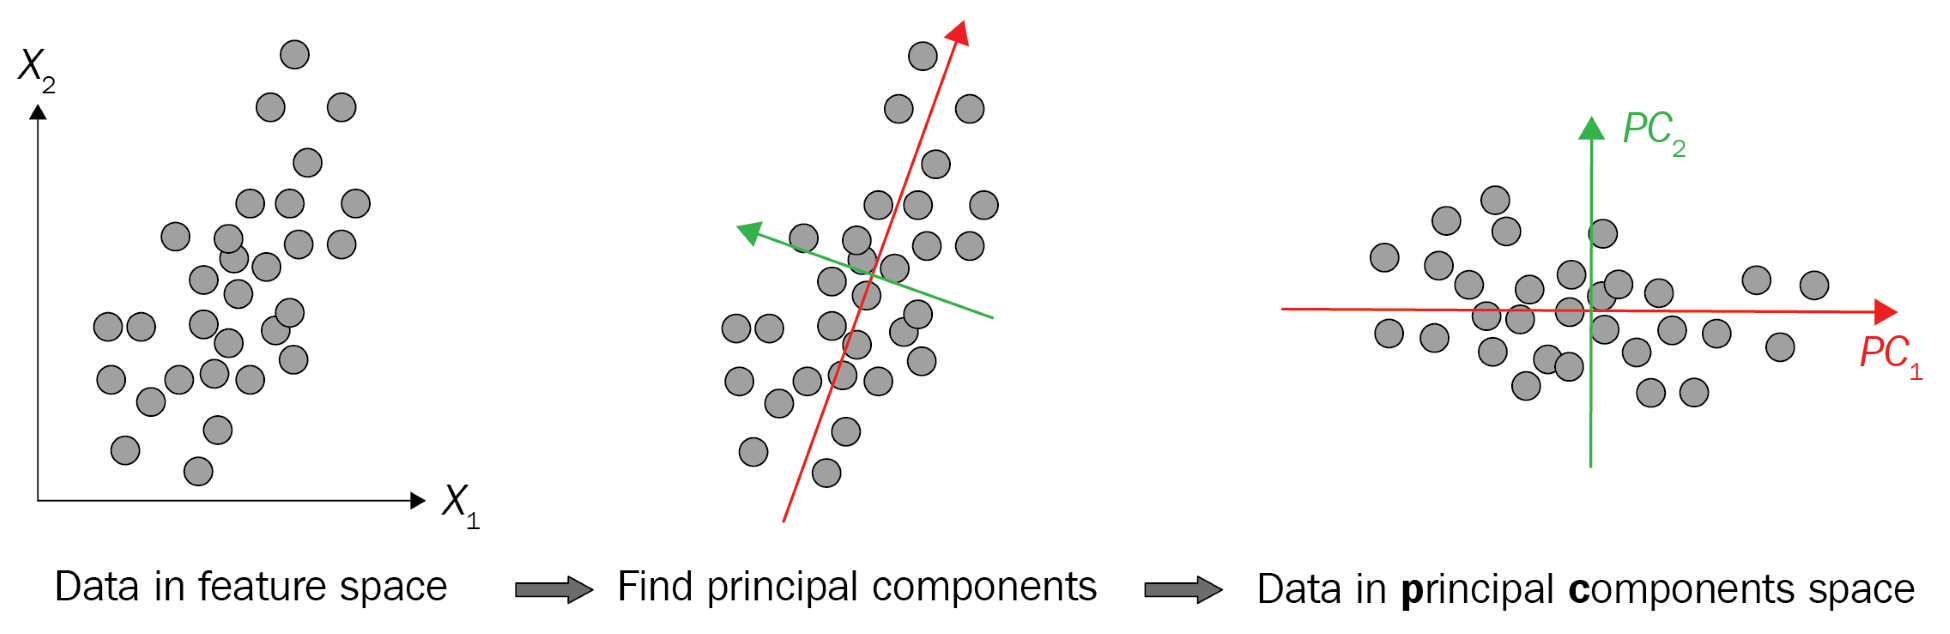

In [43]:
# Apply PCA
pca = PCA(n_components=50)  # Keep 50 components initially
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print(f"PCA Results:")
print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"Reduced dimensions: {X_pca.shape[1]}")
print(f"Variance explained by first 10 components: {cumulative_variance_ratio[9]:.2%}")
print(f"Variance explained by first 50 components: {cumulative_variance_ratio[-1]:.2%}")

PCA Results:
Original dimensions: 160
Reduced dimensions: 50
Variance explained by first 10 components: 25.39%
Variance explained by first 50 components: 74.59%


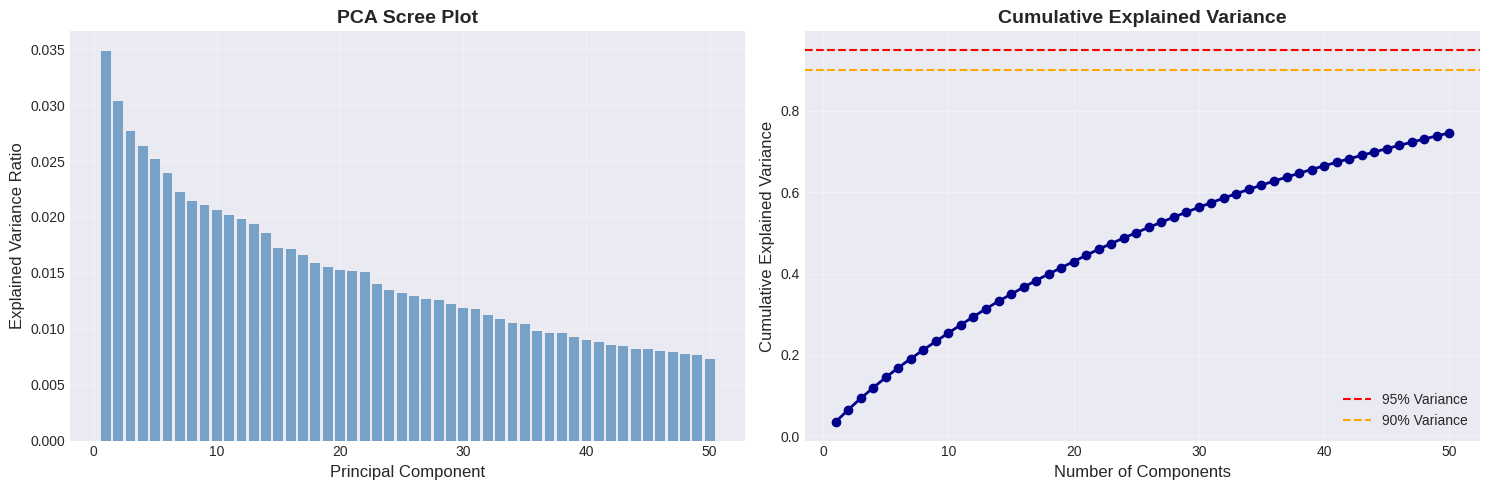


Components needed for 90% variance: 1
Components needed for 95% variance: 1


In [45]:
# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
axes[0].bar(range(1, 51), explained_variance_ratio, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cumulative explained variance
axes[1].plot(range(1, 51), cumulative_variance_ratio, marker='o', linestyle='-', color='darkblue', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components needed for 90% and 95% variance
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

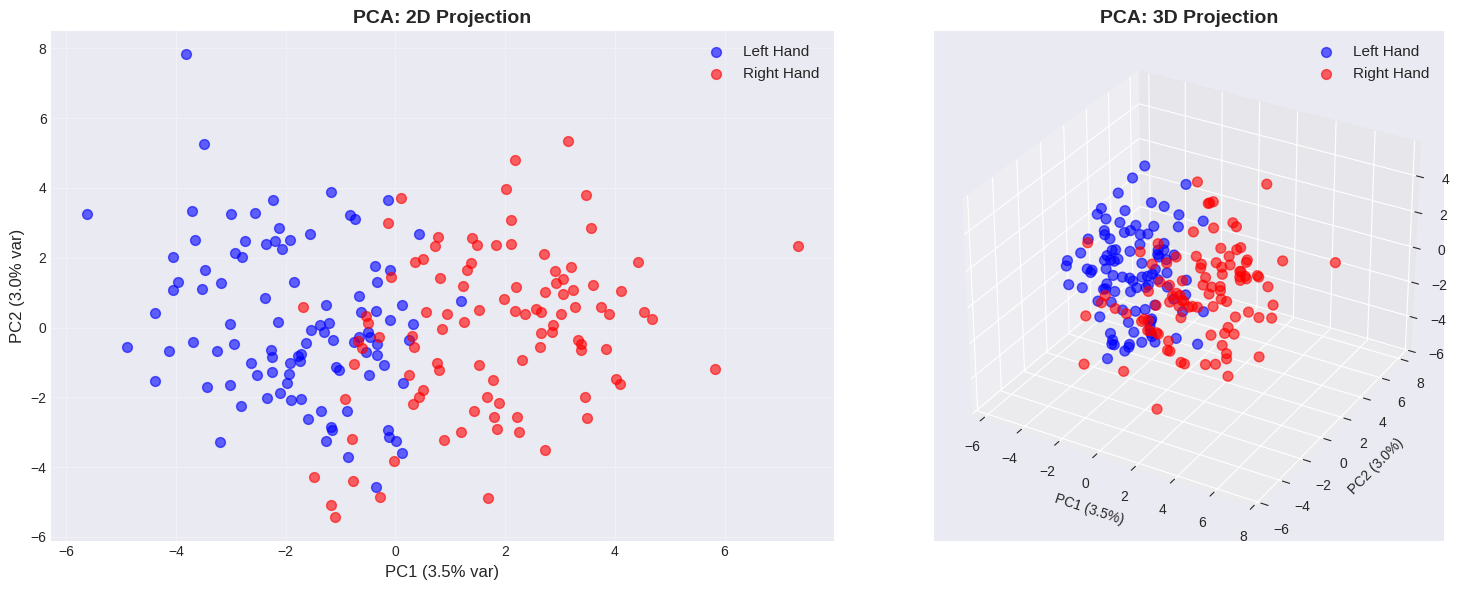


PCA captures variance but doesn't explicitly maximize class separation.


In [46]:
# Reduce to 2D and 3D for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Visualize PCA results
fig = plt.figure(figsize=(16, 6))

# 2D visualization
ax1 = fig.add_subplot(121)
scatter1 = ax1.scatter(X_pca_2d[y==0, 0], X_pca_2d[y==0, 1],
                       c='blue', label='Left Hand', alpha=0.6, s=50)
scatter2 = ax1.scatter(X_pca_2d[y==1, 0], X_pca_2d[y==1, 1],
                       c='red', label='Right Hand', alpha=0.6, s=50)
ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax1.set_title('PCA: 2D Projection', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 3D visualization
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_pca_3d[y==0, 0], X_pca_3d[y==0, 1], X_pca_3d[y==0, 2],
           c='blue', label='Left Hand', alpha=0.6, s=50)
ax2.scatter(X_pca_3d[y==1, 0], X_pca_3d[y==1, 1], X_pca_3d[y==1, 2],
           c='red', label='Right Hand', alpha=0.6, s=50)
ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=10)
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=10)
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=10)
ax2.set_title('PCA: 3D Projection', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

print(f"\nPCA captures variance but doesn't explicitly maximize class separation.")

### 2.2 Linear Discriminant Analysis (LDA)

**LDA** is a supervised dimensionality reduction technique that explicitly maximizes class separation. Unlike PCA which finds directions of maximum variance, LDA finds directions that maximize the ratio of between-class variance to within-class variance.


#### Key Properties:

- **Supervised**: Uses class labels to find optimal separation
- **Maximum discrimination**: Explicitly maximizes class separability
- **Limited components**: Can extract at most (n_classes - 1) components
- **Classification-oriented**: Often used as both dimensionality reduction AND classifier

#### When to Use LDA for EEG:

- You have labeled training data
- You want maximum class discrimination
- You plan to use the reduced features for classification



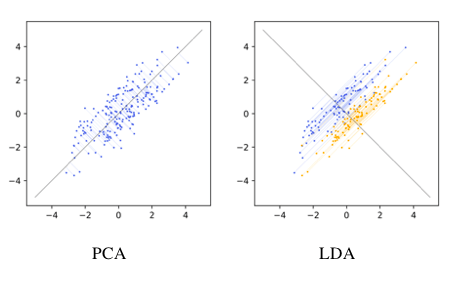


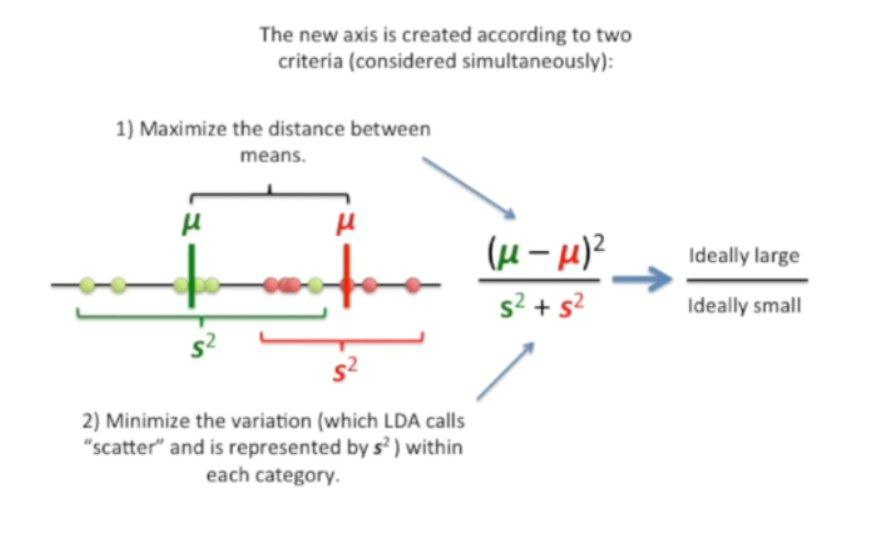

In [11]:
# Apply LDA
# For binary classification, we can only get 1 component, so let's extract it
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y)

print(f"LDA Results:")
print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"Reduced dimensions: {X_lda.shape[1]}")
print(f"\nNote: For binary classification, LDA can only extract 1 component (n_classes - 1).")
print(f"This single component is the direction that maximally separates the two classes.")

LDA Results:
Original dimensions: 160
Reduced dimensions: 1

Note: For binary classification, LDA can only extract 1 component (n_classes - 1).
This single component is the direction that maximally separates the two classes.


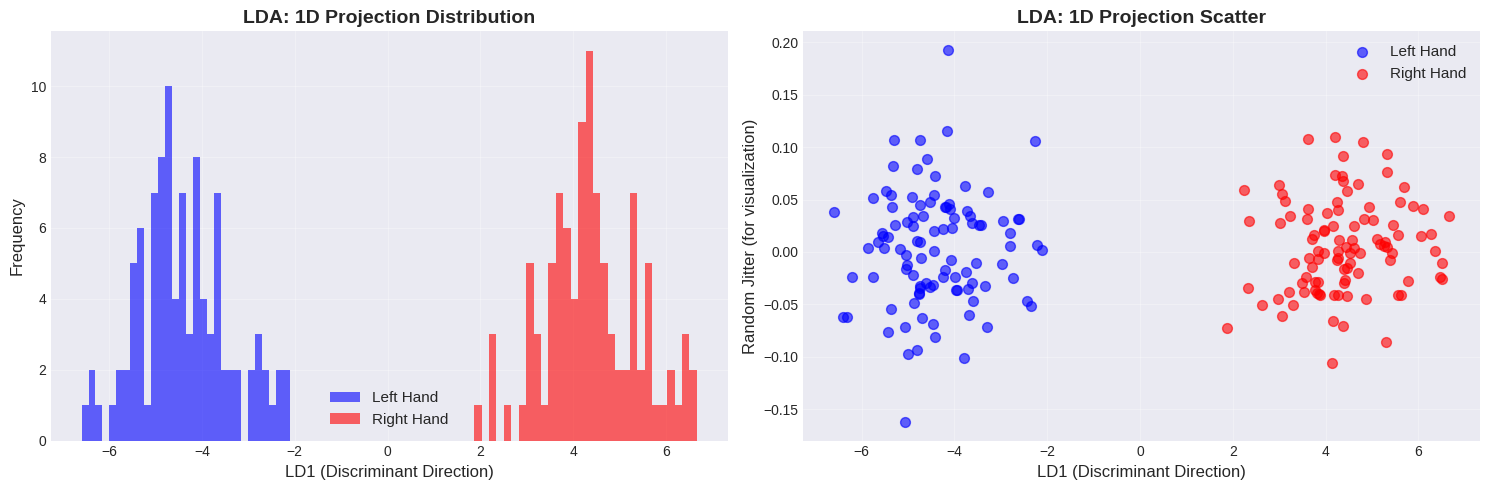

In [36]:
# Visualize LDA projection
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1D projection as histogram
axes[0].hist(X_lda[y==0], bins=30, alpha=0.6, label='Left Hand', color='blue')
axes[0].hist(X_lda[y==1], bins=30, alpha=0.6, label='Right Hand', color='red')
axes[0].set_xlabel('LD1 (Discriminant Direction)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('LDA: 1D Projection Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 1D projection as scatter (add jitter for visualization)
jitter = np.random.normal(0, 0.05, len(y))
axes[1].scatter(X_lda[y==0], jitter[y==0], c='blue', label='Left Hand', alpha=0.6, s=50)
axes[1].scatter(X_lda[y==1], jitter[y==1], c='red', label='Right Hand', alpha=0.6, s=50)
axes[1].set_xlabel('LD1 (Discriminant Direction)', fontsize=12)
axes[1].set_ylabel('Random Jitter (for visualization)', fontsize=12)
axes[1].set_title('LDA: 1D Projection Scatter', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

# 3. Data Leakage

## 3.1 What is Data Leakage?

Data leakage occurs when information from outside the training dataset is used to create the model. This leads to overly optimistic performance estimates during development, but poor performance when the model encounters truly new data in production.

Think of it this way: imagine you're preparing for an exam. If you accidentally see the exact questions that will be on the test while you're studying, you might score perfectly on the exam. However, this doesn't mean you actually learned the material well enough to apply it to different problems. Data leakage is similar—your model might perform excellently on your test set, but it hasn't truly learned generalizable patterns.


## 3.2 Type 1: Preprocessing Leakage (Feature Scaling)

One of the most common types of data leakage occurs during preprocessing, particularly when scaling features. Let's understand why this happens and how to avoid it.

### The Problem

When we use StandardScaler or any normalization technique, the scaler learns statistics (mean and standard deviation) from the data. If we fit the scaler on the entire dataset before splitting into train and test sets, the scaler learns information about the test set, which then influences how we transform the training data. This is leakage.

### The Correct Approach

Always fit the scaler only on the training data, then use that fitted scaler to transform both training and test data. This ensures that no information from the test set influences the training process.

## 3.3 Type 2: Temporal Leakage

EEG signals are time-series data, and consecutive trials are often correlated. If we randomly split trials without considering temporal order, we might place highly correlated trials in both training and test sets. This is particularly problematic when trials are closely spaced in time or when there are slow-changing factors (like subject alertness or electrode impedance drift).

### The Problem

In EEG experiments, trials collected close together in time often share similar characteristics due to:
- Subject's mental state evolving slowly
- Gradual changes in electrode contact quality
- Environmental factors (room temperature, noise)
- Learning effects or fatigue

If we split the data randomly, our model might simply learn to identify these temporal patterns rather than the actual cognitive states we're interested in.

### The Correct Approach

For time-series data, use temporal splits where training data comes from earlier time points and test data from later time points. This better simulates real-world deployment where we predict future data.

## 3.4 Type 3: Subject-Level Leakage

In EEG studies, we typically collect multiple trials from each subject. If we randomly split trials without considering subject identity, we might have trials from the same subject in both training and test sets. This is problematic because the model can learn subject-specific patterns rather than generalizable patterns.

### The Problem

Each person's brain activity has unique characteristics:
- Individual differences in brain anatomy
- Personal patterns in neural responses
- Subject-specific artifacts

If trials from the same subject appear in both training and test sets, the model might achieve high accuracy by learning to identify subjects rather than learning the actual cognitive states we care about. This leads to poor generalization to new subjects.

### The Correct Approach

Use subject-independent splitting: ensure that all trials from a particular subject are in either the training or test set, never both. This is called "leave-subjects-out" validation and provides a realistic estimate of how well the model will generalize to new people.

---

# 4. Imbalanced Data

## 4.1 What is Imbalanced Data?

Imbalanced data occurs when one class significantly outnumbers another in your dataset. This is extremely common in EEG-based classification tasks:

- **Seizure detection**: Seizure events are rare compared to normal brain activity
- **Error detection**: Error-related potentials occur less frequently than correct responses
- **Sleep stage classification**: Some sleep stages occupy less time than others
- **Emotion recognition**: Certain emotional states may be less common in experimental paradigms

### Why is Imbalanced Data Problematic?

Consider a seizure detection scenario where only 1% of EEG segments contain seizures. A naive model could achieve 99% accuracy by simply predicting "no seizure" for every sample! This is clearly not useful. The model has learned to exploit the class imbalance rather than learning meaningful patterns.

Standard machine learning algorithms are typically designed assuming balanced class distributions. When faced with imbalanced data, they often:
- Become biased toward the majority class
- Achieve high overall accuracy but poor minority class detection
- Fail to learn meaningful patterns in the minority class


## 4.2 Resampling Techniques

One of the most effective approaches to handling imbalanced data is resampling—modifying the dataset to balance the class distribution. There are three main strategies:

### 1. Random Oversampling
Randomly duplicate minority class samples until classes are balanced. Simple but can lead to overfitting since we're creating exact copies.

### 2. Random Undersampling
Randomly remove majority class samples until classes are balanced. Simple but discards potentially useful data.

### 3. SMOTE (Synthetic Minority Over-sampling Technique)
Creates synthetic samples by interpolating between existing minority class samples. More sophisticated than simple duplication and less prone to overfitting.

### 4. Tomek Links
Removes majority class samples that are very close to minority class samples, cleaning up the decision boundary. Often combined with oversampling.

### 5. SMOTE + Tomek Links
Combines oversampling minority class with cleaning the decision boundary. Often provides the best of both approaches.

Let's implement and compare all these methods on our EEG dataset.

## 4.3 Algorithm-Level Approaches: Class Weights

Instead of modifying the dataset, we can modify the learning algorithm itself to handle imbalanced data. Most scikit-learn classifiers support a `class_weight` parameter that penalizes misclassifications of the minority class more heavily.

### How Class Weights Work

Class weights adjust the loss function so that the model pays more attention to minority class errors. The algorithm assigns higher costs to misclassifying minority class samples, forcing the model to work harder to get them correct.

**Setting class weights:**
- `'balanced'`: Automatically adjusts weights inversely proportional to class frequencies
- Custom dictionary: Manually specify weights for each class

### Advantages of Class Weights
- No need to modify the dataset
- Works well when you don't want to increase training set size
- Can be fine-tuned for specific cost considerations
- Computationally efficient

Let's compare models with and without class weights across different algorithms.

---

# Mini-Project Assignment: DEAP Dataset Arousal Classification

## Project Overview

You will work with the DEAP (Database for Emotion Analysis using Physiological signals) dataset to build a classifier for predicting arousal levels from EEG signals. This project will require you to apply everything you learned today about dimension reduction, data leakage prevention and handling imbalanced data.

## Dataset Description

The DEAP dataset contains EEG and physiological recordings from 32 participants watching 40 music videos. Each trial is labeled with valence, arousal, dominance, and liking ratings on a scale of 1-9.

**Your task**: Classify arousal into two classes:
- **Low Arousal** (class 0): arousal rating ≤ 5
- **High Arousal** (class 1): arousal rating > 5



## Project Requirements

1. **Compare resampling techniques**
   - Implement at least THREE different resampling methods:
     * Random oversampling
     * Random undersampling
     * SMOTE
   - Use proper cross-validation (stratified K-fold) to evaluate each method
   - Compare results using precision, recall, F1-score
   - CRITICAL: Apply resampling ONLY to training folds, never to test data!

2. **Test algorithm-level approaches**
   - Implement class weighting for at least TWO different algorithms
   - Compare performance with and without class weights
   - Analyze the trade-off between precision and recall


## Bonus Challenges (Optional)

For extra credit, consider:

1. **Multi-class classification**: Divide arousal into 3 or more levels
2. **Feature engineering**: Extract additional EEG features beyond band powers or use dimension reduction methods
3. **Ensemble methods**: Combine multiple models for improved performance
4. **Temporal analysis**: Investigate how arousal changes over time within trials
5. **Subject-specific models**: Compare subject-independent vs subject-specific approaches
